This code can be used to evaluate the CSXA dataset results

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
import cv2

In [7]:
data_path = os.path.join('..','data','CSXA')
output_path = os.path.join(data_path,'finalfinal')
img_path = os.path.join(data_path,'imgs')
gt_path = os.path.join(data_path,'gts')

VERTEBRA_DICT = {'C1':0,'C2':1,'C3':2,'C4':3,'C5':4,'C6':5,'C7':6,'T1':7,'T2':8,'T3':9}
VERTEBRA_DICT_REVERSED = {0:'C1',1:'C2',2:'C3',3:'C4',4:'C5',5:'C6',6:'C7',7:'T1',8:'T2',9:'T3'}

threshold = 0.9

id_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(output_path,'masks'))]

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def dice(pred, gt):
    return 2*np.sum(pred & (gt==1))/(np.sum(pred)+np.sum(gt))

def binary_mask_from_logits(mask,threshold):
    output = (torch.sigmoid(mask) > threshold).to(torch.uint8)
    return np.array(output[0,:,:])

def gaussian_smooth(mask):
    smoothed_mask = cv2.GaussianBlur(mask, (15,15), sigmaX=20)
    _, final_mask = cv2.threshold(smoothed_mask, 0.5, 1, cv2.THRESH_BINARY)
    return final_mask



In [20]:
pred_mask_array = {id:[] for id in id_list}
pred_mask_dict = {id:{} for id in id_list}
gt_mask_dict = {}
missed_vertebrae = {id:[] for id in id_list}
dice_scores = {id:{} for id in id_list}
dice_scores_dict = {}
dice_scores_dict_ignore_misses = {}


for i,id in enumerate(id_list):

    id_gt_filenames = [file for file in os.listdir(gt_path) if file.split('_')[0] == id]
    gt_mask_dict[id] = {filename.split('.')[0].split('_')[1]: np.load(os.path.join(gt_path,filename))['arr_0'] for filename in id_gt_filenames}
    pred_mask_array[id] = [mask for mask in np.load(os.path.join(output_path,'masks',id+'.npz'))['masks']]

    
    for level,gt in gt_mask_dict[id].items():

        for mask in pred_mask_array[id]:

            mask = binary_mask_from_logits(torch.as_tensor(mask),threshold=threshold)
            dice_score = dice(mask,gt)

            if dice_score > 0.4:

                pred_mask_dict[id][level] = mask
                dice_scores[id][level] = dice_score
        
        if level not in pred_mask_dict[id].keys():
            missed_vertebrae[id].append(level)
    
    dice_scores_dict[id] = sum(dice_scores[id].values())/len(gt_mask_dict[id])
    dice_scores_dict_ignore_misses[id] = sum(dice_scores[id].values())/len(dice_scores[id])


C:\Users\simon\AppData\Local\Temp\ipykernel_12836\3834732714.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(output[0,:,:])


In [10]:
long_dice_scores = {}

for id,scores in dice_scores.items():
    for level,score in scores.items():
        long_dice_scores[(level,id)] = score

In [21]:
for level in ['C3','C4','C5','C6','C7']:
    print(level,sum([v[level] for v in dice_scores.values() if level in v.keys()])/sum([1 for v in gt_mask_dict.values() if level in v.keys()]),sum([1 for v in dice_scores.values() if level in v.keys()]))
# print(1-11/(sum([len(v) for v in gt_mask_dict.values()])+11))

C3 0.9308273663058692 11
C4 0.9358959125293871 11
C5 0.9377649787159218 11
C6 0.9283781182832137 11
C7 0.9344972199434946 11


['0195127', '0125124', '0047040', '0144125'] [np.float64(0.9502826337337691), np.float64(0.9469690270171984), np.float64(0.9448547250406829), np.float64(0.9427760284391059)]


C:\Users\simon\AppData\Local\Temp\ipykernel_12836\3834732714.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(output[0,:,:])


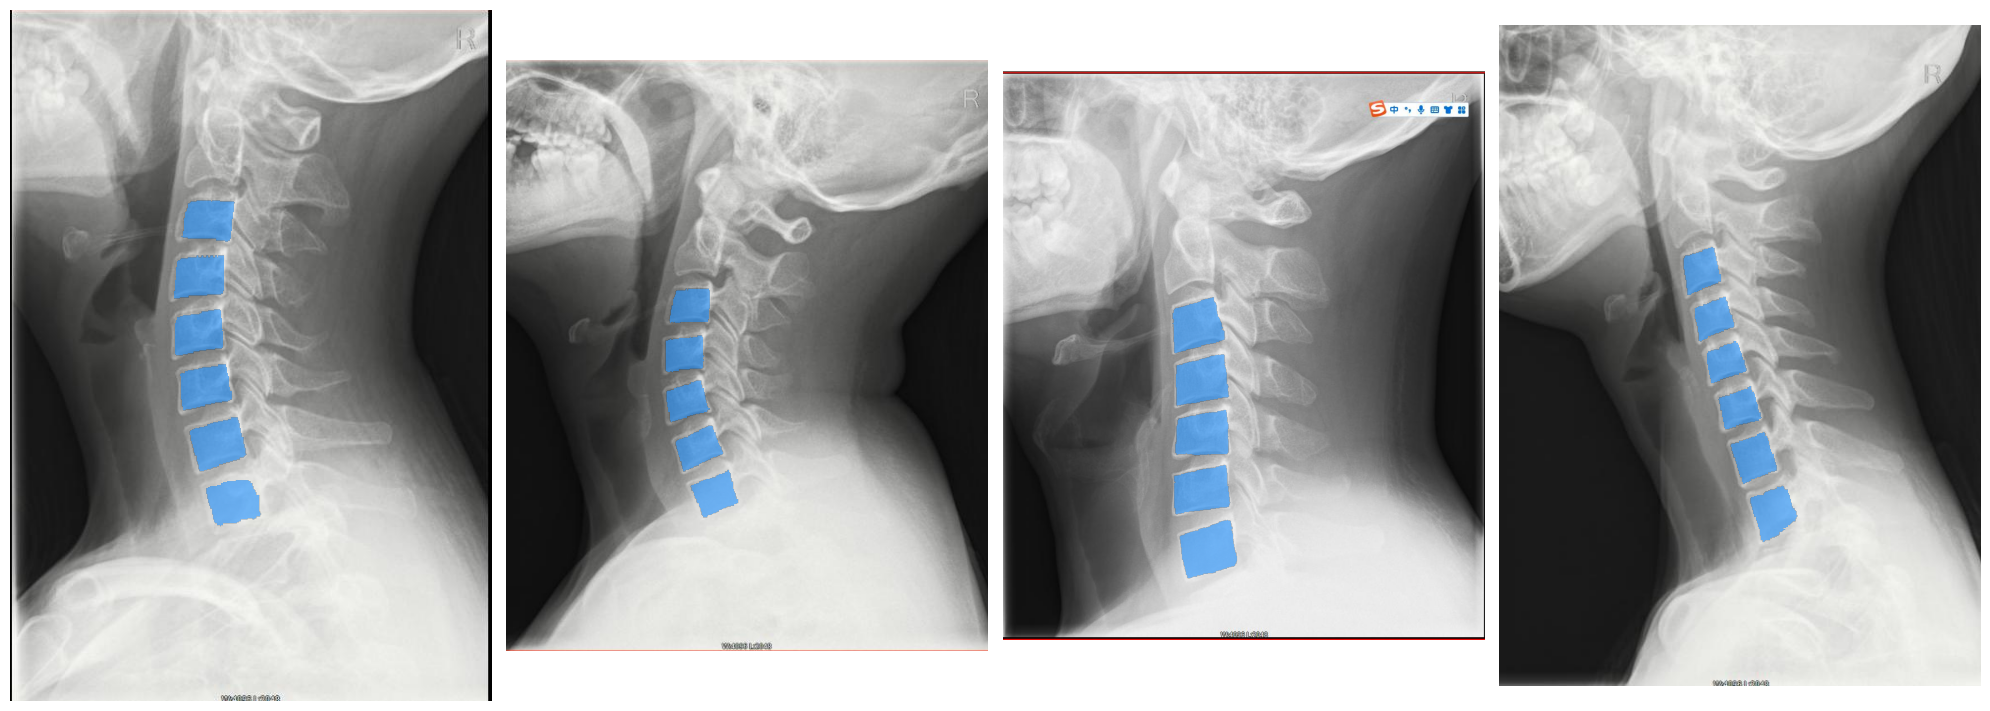

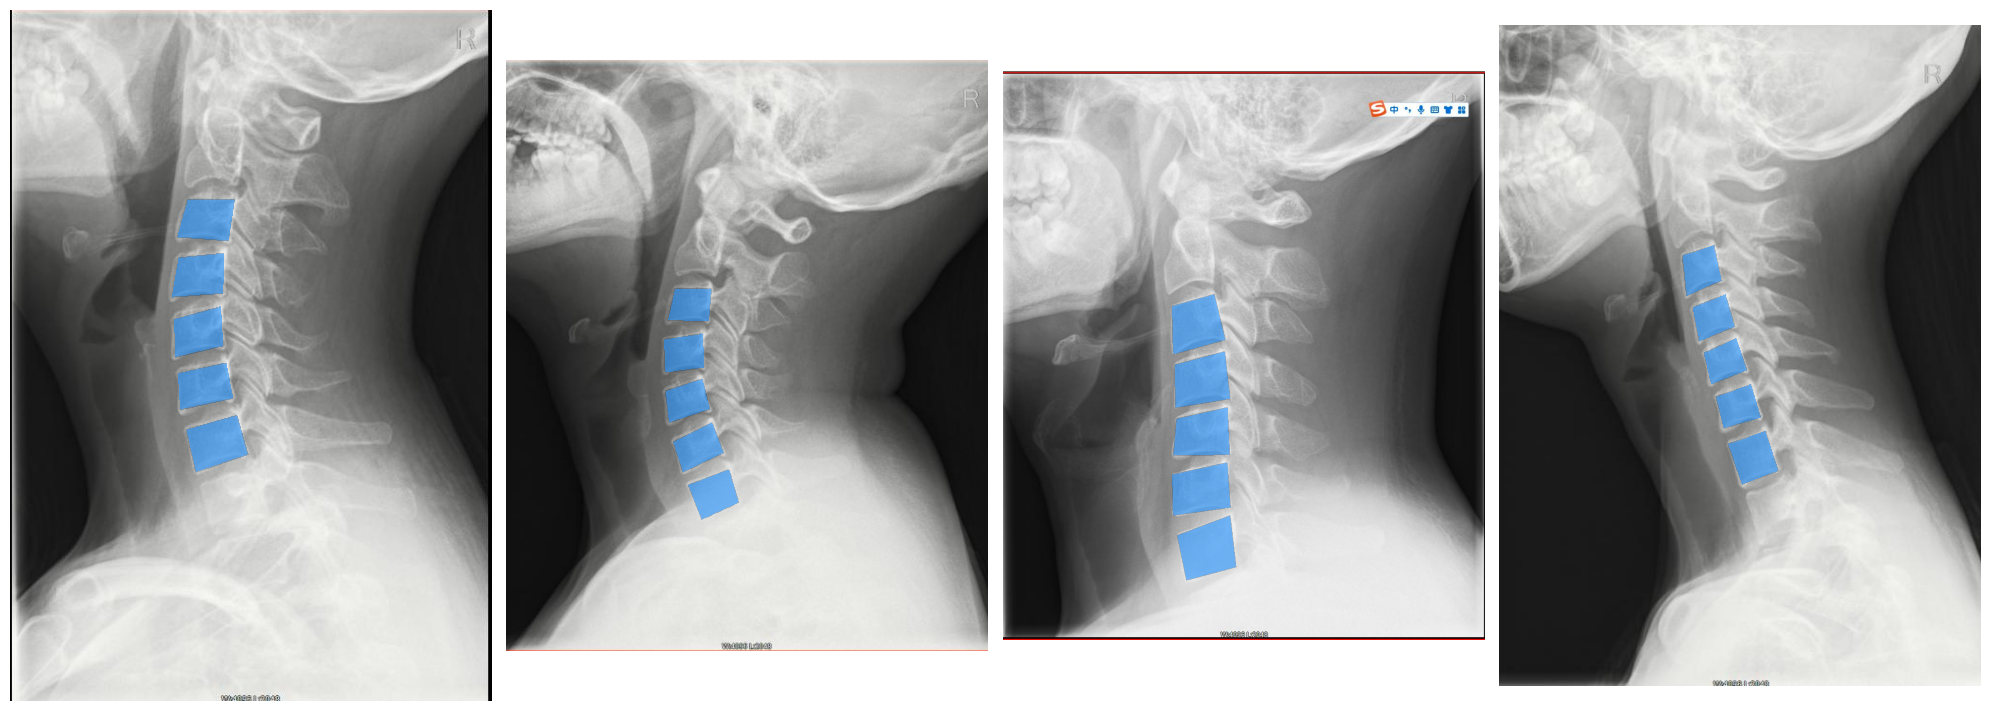

In [23]:
sorted_items = sorted(dice_scores_dict.items(), key=lambda x: x[1], reverse=True)
top_four_ids = [item[0] for item in sorted_items[0:4]]
print(top_four_ids,[dice_scores_dict[id] for id in top_four_ids])

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for n,id in enumerate(top_four_ids):
    img = Image.open(os.path.join(img_path,id+'.jpg')).convert('RGB')
    ax[n].imshow(img)
    for mask in pred_mask_array[id]:
        show_mask(binary_mask_from_logits(torch.as_tensor(mask),0.9), ax[n])
    ax[n].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for n,id in enumerate(top_four_ids):
    img = Image.open(os.path.join(img_path,id+'.jpg')).convert('RGB')
    ax[n].imshow(img)
    for mask in gt_mask_dict[id].values():
        show_mask(mask, ax[n])
    ax[n].axis('off')
plt.tight_layout()
plt.show()

In [19]:
print(sum(dice_scores_dict.values())/len(dice_scores_dict))

0.9334727191555774


['0241128', '0259129', '0503137', '0335133'] [np.float64(0.9053986262084666), np.float64(0.9135416156362725), np.float64(0.9177452996980012), np.float64(0.9302767469818554)]


C:\Users\simon\AppData\Local\Temp\ipykernel_12836\3834732714.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(output[0,:,:])


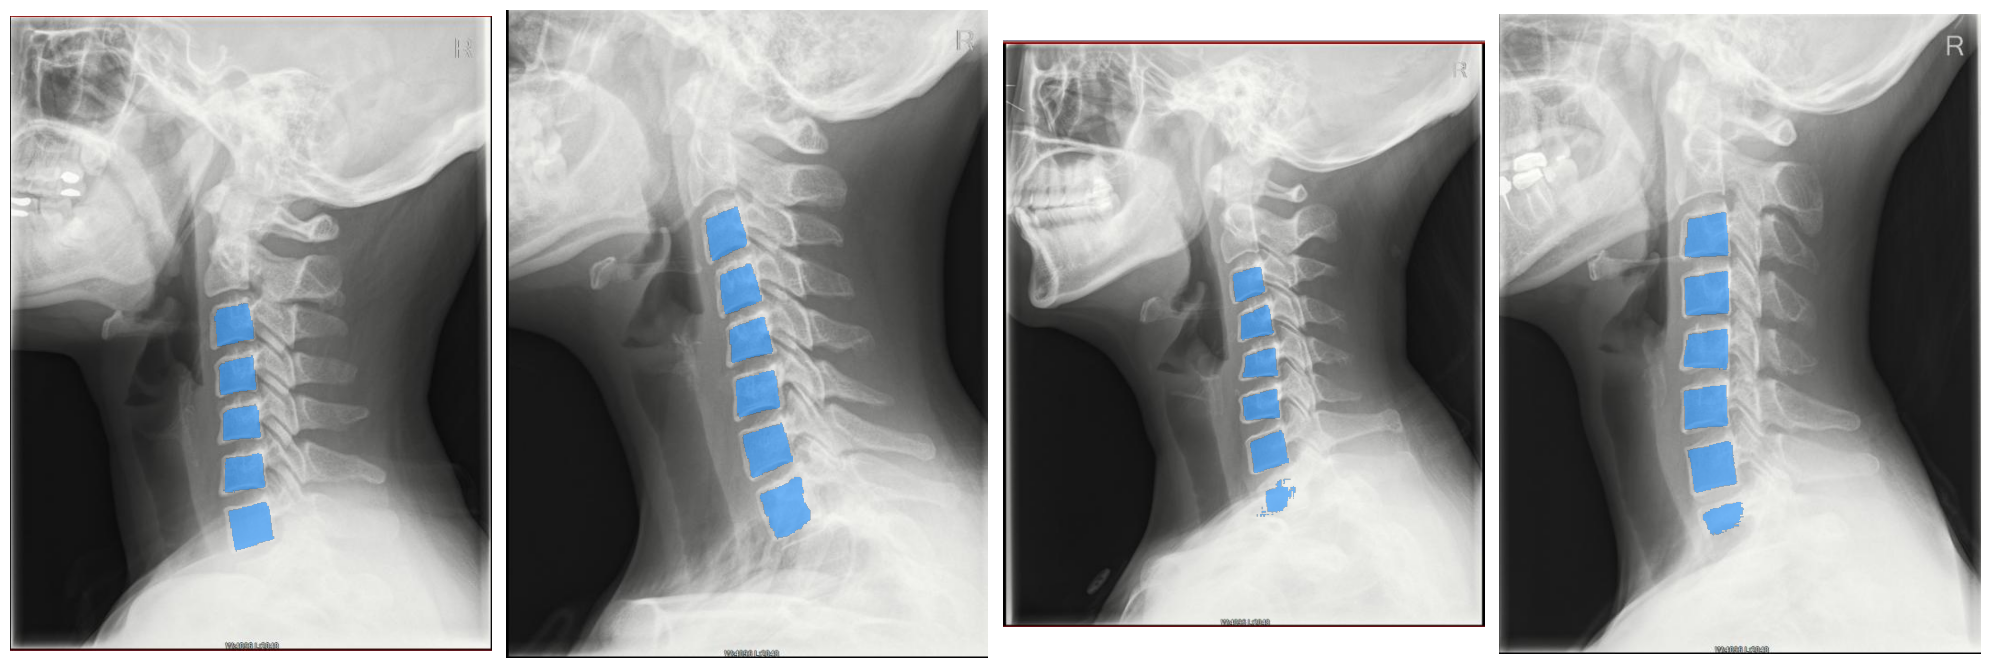

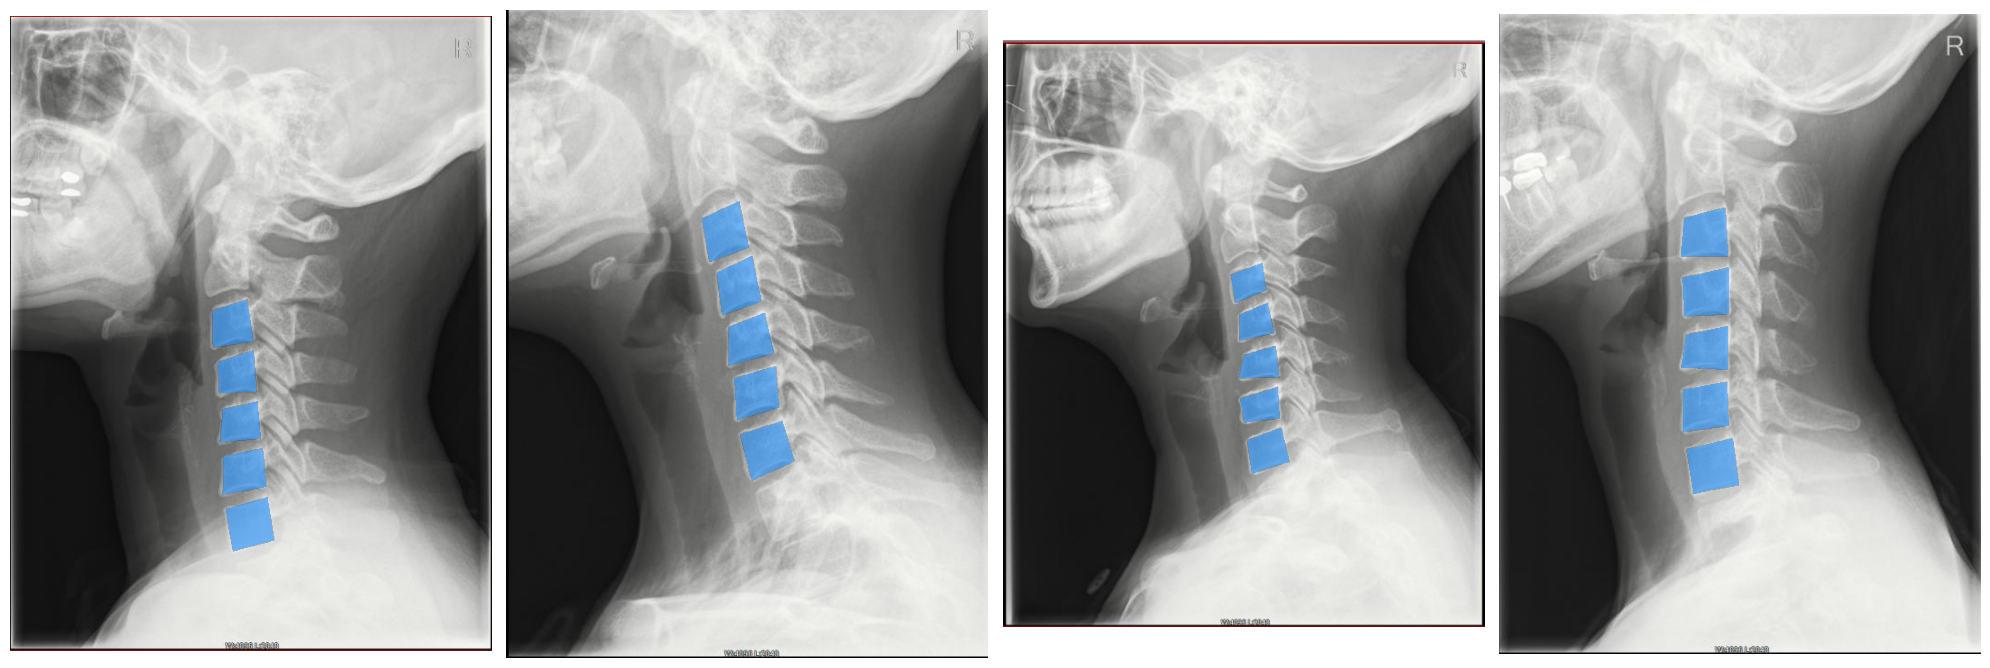

In [15]:
sorted_items = sorted(dice_scores_dict.items(), key=lambda x: x[1], reverse=False)
bottom_four_ids = [item[0] for item in sorted_items[0:4]]

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
print(bottom_four_ids,[dice_scores_dict[id] for id in bottom_four_ids])

for n,id in enumerate(bottom_four_ids):
    img = Image.open(os.path.join(img_path,id+'.jpg')).convert('RGB')
    ax[n].imshow(img)
    for mask in pred_mask_array[id]:
        mask = binary_mask_from_logits(torch.as_tensor(mask),threshold=threshold)
        show_mask(mask, ax[n])
    ax[n].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for n,id in enumerate(bottom_four_ids):
    img = Image.open(os.path.join(img_path,id+'.jpg')).convert('RGB')
    ax[n].imshow(img)
    for mask in gt_mask_dict[id].values():
        show_mask(mask, ax[n])
    ax[n].axis('off')
plt.tight_layout()
plt.show()

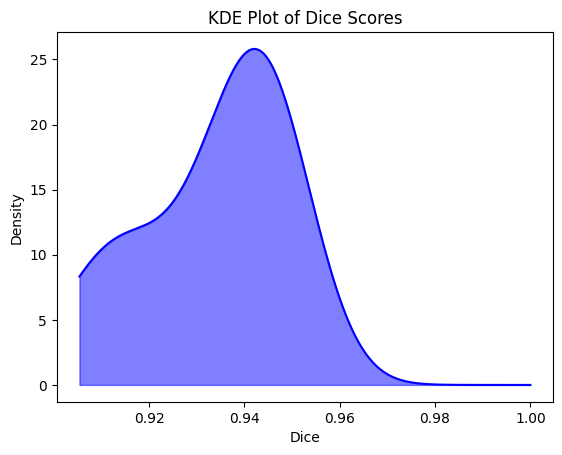

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

array = np.array([dice_scores_dict[id] for id in dice_scores_dict.keys()])

# Compute the KDE
kde = gaussian_kde(array)

# Create a range of values for plotting the KDE
x_range = np.linspace(min(array), 1.0, 1000)

# Evaluate the KDE on the range of values
kde_values = kde(x_range)

# Plot the KDE
plt.plot(x_range, kde_values, color='blue', label='KDE')
plt.fill_between(x_range, kde_values, color='blue', alpha=0.5)

# Add title and labels
plt.title('KDE Plot of Dice Scores')
plt.xlabel('Dice')
plt.ylabel('Density')

# Show the plot
plt.show()